In [16]:
import pandas as pd
import numpy as np

def process_gesture_data(file_path):
    # 读取 CSV 文件
    df = pd.read_csv(file_path, header=None)
    
    # 移除第一列（时间列无用）
    df = df.iloc[:, 1:].reset_index(drop=True)
    
    # 识别手势分割行（全 0 行）
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    # 分割手势数据
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:  # 确保包含最后一个手势
        if start_idx < idx:  # 避免连续空行导致空片段
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    processed_gestures = []
    
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        # 如果数据多于1000，直接截断
        if data.shape[0] > 1000:
            data = data[:1000]
        
        # 插值到 1000 采样点（如果不足）
        if data.shape[0] < 1000:
            x_old = np.linspace(0, 1, data.shape[0])
            x_new = np.linspace(0, 1, 1000)
            data = np.array([np.interp(x_new, x_old, data[:, j]) for j in range(data.shape[1])]).T
        
        # 切分窗口：100 个点一个窗口，步长 50
        windows = []
        for start in range(0, 1000 - 100 + 1, 50):
            windows.append(data[start:start + 100])
        
        # 转换成 [1, window_num, 100, 10]
        windows = np.array(windows)
        windows = np.expand_dims(windows, axis=0)  # 额外的 batch 维度
        
        # 记录手势编号
        gesture_id = np.full((1, windows.shape[1], 100, 1), i + 1)  # 手势编号从 1 开始
        windows = np.concatenate((gesture_id, windows), axis=-1)  # 拼接到第一个通道
        
        # 存储到列表
        processed_gestures.append(windows)
    
    # 合并所有手势数据
    final_data = np.concatenate(processed_gestures, axis=0)  # [gesture_count, window_num, 100, 11]
    return final_data


In [17]:
# 示例调用
file_path = r"new_collect\fzh\sensor_data4.csv"
gesture_data = process_gesture_data(file_path)
print("Final data shape:", gesture_data.shape)

Detected empty rows at indices: [999, 2009, 3016, 4023]
Processing Gesture 1 with 999 samples
Processing Gesture 2 with 1009 samples
Processing Gesture 3 with 1006 samples
Processing Gesture 4 with 1006 samples
Final data shape: (4, 19, 100, 11)


# visualization

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_gesture_data(file_path):
    # 读取 CSV 文件
    df = pd.read_csv(file_path, header=None)
    
    # 移除第一列（时间列无用）
    df = df.iloc[:, 1:].reset_index(drop=True)
    
    # 识别手势分割行（全 0 行）
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    # 分割手势数据
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:  # 确保包含最后一个手势
        if start_idx < idx:  # 避免连续空行导致空片段
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    # 计算行列数
    num_gestures = len(gestures)
    cols = 2  # 每行 2 个图
    rows = (num_gestures + cols - 1) // cols  # 计算需要的行数
    
    # 创建图形
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()
    
    # 仅绘制一次图例
    legend_labels = [f'Channel {j+1}' for j in range(gestures[0].shape[1])]
    
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        # 画每个手势的所有通道数据
        for j in range(data.shape[1]):
            axes[i].plot(data[:, j])
        
        axes[i].set_title(f'Gesture {i+1}')
        axes[i].set_xlabel('Samples')
        axes[i].set_ylabel('Sensor Values')
    
    # 在最后一个子图上添加图例
    axes[-1].legend(legend_labels, loc='upper right')
    
    # 移除多余的子图
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


Detected empty rows at indices: [999, 2009, 3016, 4023]
Processing Gesture 1 with 999 samples
Processing Gesture 2 with 1009 samples
Processing Gesture 3 with 1006 samples
Processing Gesture 4 with 1006 samples


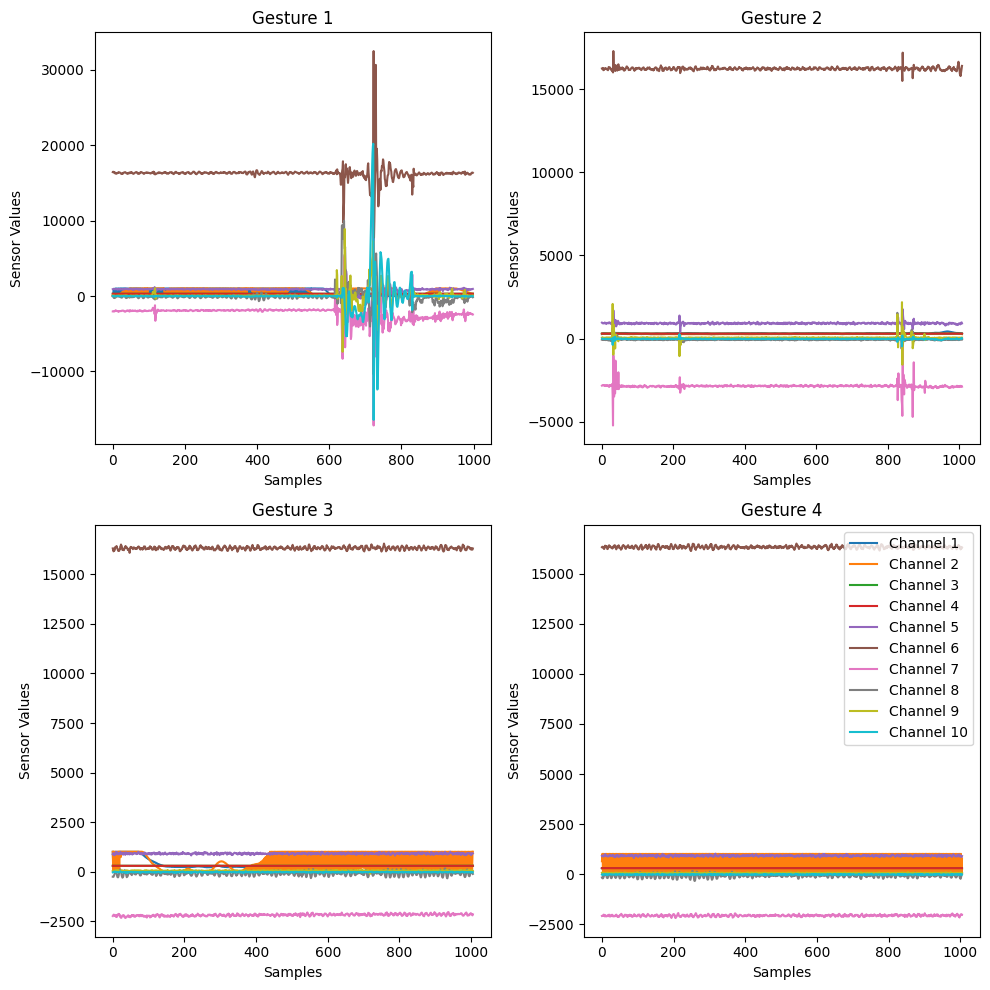

In [25]:
# 示例调用
file_path = r"new_collect\fzh\sensor_data4.csv"
visualize_gesture_data(file_path)

In [43]:
import os
import re
import pandas as pd
import numpy as np

def process_gesture_data(file_path):
    df = pd.read_csv(file_path, header=None)
    df = df.iloc[:, 1:].reset_index(drop=True)  # 移除时间列
    
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:
        if start_idx < idx:
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    processed_gestures = []
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        if data.shape[0] > 1000:
            data = data[:1000]
        if data.shape[0] < 1000:
            x_old = np.linspace(0, 1, data.shape[0])
            x_new = np.linspace(0, 1, 1000)
            data = np.array([np.interp(x_new, x_old, data[:, j]) for j in range(data.shape[1])]).T
        
        windows = []
        for start in range(0, 1000 - 100 + 1, 50):
            windows.append(data[start:start + 100])
        
        windows = np.array(windows)
        windows = np.expand_dims(windows, axis=0)
        gesture_id = np.full((1, windows.shape[1], 100, 1), i + 1)
        windows = np.concatenate((gesture_id, windows), axis=-1)
        processed_gestures.append(windows)
    
    final_data = np.concatenate(processed_gestures, axis=0)
    return final_data

def process_all_gesture_files(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    all_files = sorted(all_files, key=lambda x: int(re.search(r"sensor_data(\d+).csv", x).group(1)))
    all_files = [os.path.join(folder_path, f) for f in all_files]
    
    all_data = []
    all_labels = []
    
    for label, file_path in enumerate(all_files, start=1):
        print(f"Processing {file_path} with label {label}")
        data = process_gesture_data(file_path)
        data[:, :, :, 0] = label  # 设置第一个通道为文件对应的标签
        all_data.append(data)
        all_labels.append(np.full((data.shape[0],), label))
    
    final_dataset = np.concatenate(all_data, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)
    data_path = os.path.join(folder_path,"processed_gesture_data.npy")
    label_path = os.path.join(folder_path, "gesture_labels.npy")
    np.save(data_path, final_dataset)
    np.save(label_path, final_labels)
    print("Processed data and labels saved.")
    
    return final_dataset, final_labels



In [44]:
folder_path = r"new_collect\fzh"  # 修改为你的CSV文件夹路径
final_data, final_labels = process_all_gesture_files(folder_path)
print("Final data shape:", final_data.shape)
print("Final labels shape:", final_labels.shape)

Processing new_collect\fzh\sensor_data1.csv with label 1
Detected empty rows at indices: []
Processing Gesture 1 with 2001 samples
Processing new_collect\fzh\sensor_data2.csv with label 2
Detected empty rows at indices: [992]
Processing Gesture 1 with 992 samples
Processing Gesture 2 with 3019 samples
Processing new_collect\fzh\sensor_data3.csv with label 3
Detected empty rows at indices: []
Processing Gesture 1 with 4025 samples
Processing new_collect\fzh\sensor_data4.csv with label 4
Detected empty rows at indices: [999, 2009, 3016, 4023]
Processing Gesture 1 with 999 samples
Processing Gesture 2 with 1009 samples
Processing Gesture 3 with 1006 samples
Processing Gesture 4 with 1006 samples
Processed data and labels saved.
Final data shape: (8, 19, 100, 11)
Final labels shape: (8,)


In [37]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """
    加载预处理的手势数据，并拆分为训练集和测试集。
    
    参数：
    root_path (str): 存储 processed_gesture_data.npy 和 gesture_labels.npy 的根目录
    test_size (float): 测试集比例，默认 20%
    random_state (int): 随机种子，确保可复现性
    
    返回：
    X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
    """
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path)
    y = np.load(label_path)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test


In [38]:
# 示例调用
data_folder = r"new_collect\fzh"  # 修改为你的数据路径
X_train, X_test, y_train, y_test = load_data(data_folder)

Loading processed data...


ValueError: Object arrays cannot be loaded when allow_pickle=False